In [8]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import os

In [9]:
filepath = os.getcwd()+"/Ar46_4D.hdf5"
file = h5py.File(filepath, 'r')
data = file[list(file.keys())[0]]
keys = ['train', 'val', 'test']

In [10]:
def down_scale(event):

    RANGES = {
                'MIN_X': -270.0,
                'MAX_X': 270.0,
                'MIN_Y': -270.0,
                'MAX_Y': 270.0,
                'MIN_Z': -185.0,
                'MAX_Z': 1155.0,
                'MIN_LOG_A': 0.0,
                'MAX_LOG_A': 8.60
            }
    
    event[:, 0] = (event[:, 0] - RANGES['MIN_X'])/(RANGES['MAX_X'] - RANGES['MIN_X'])
    event[:, 1] = (event[:, 1] - RANGES['MIN_Y'])/(RANGES['MAX_Y'] - RANGES['MIN_Y'])
    event[:, 2] = (event[:, 2] - RANGES['MIN_Z'])/(RANGES['MAX_Z'] - RANGES['MIN_Z'])
    event[:, 3] = (np.log(event[:, 3]) - RANGES['MIN_LOG_A'])/(RANGES['MAX_LOG_A'] - RANGES['MIN_LOG_A'])

    return event


(256, 4)


/tmp/ipykernel_491139/91147995.py:17: RuntimeWarning: divide by zero encountered in log
  event[:, 3] = (np.log(event[:, 3]) - RANGES['MIN_LOG_A'])/(RANGES['MAX_LOG_A'] - RANGES['MIN_LOG_A'])


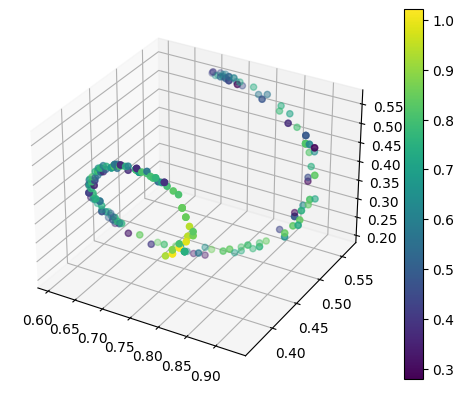

In [11]:
fig, ax = plt.subplots(1, 1, subplot_kw=dict(projection='3d'))

ev = data['train'][0]
print(ev.shape)
ev = down_scale(ev)

cb = ax.scatter(ev[:, 0], ev[:, 2], ev[:, 1], c=ev[:, 3])
fig.colorbar(cb)
plt.show()

In [13]:
for k in keys:
    scaled_data = np.ndarray(data[k].shape)
    for i, event in enumerate(data[k]):
        scaled_data[i] = down_scale(event)
    np.save(f'{os.getcwd()}/simulated/256c/Ar46_{k}.npy', scaled_data)

/tmp/ipykernel_491139/91147995.py:17: RuntimeWarning: divide by zero encountered in log
  event[:, 3] = (np.log(event[:, 3]) - RANGES['MIN_LOG_A'])/(RANGES['MAX_LOG_A'] - RANGES['MIN_LOG_A'])


In [14]:
def cut_event(origin, event, k):
    '''
    Cuts the k-nearest points to an origin in an event
    '''

    dists = np.ndarray(len(event))

    for i, point in enumerate(event):
        d = np.sqrt( np.square(point[0] - origin[0]) + np.square(point[1] - origin[1]) )
        dists[i] = d

    idxs = np.argsort(dists)
    cut = event[idxs[k:]]

    if cut.shape[-1] > 4:
        return cut[:, :4]
    elif cut.shape[-1] == 4:
        return cut
    else:
        raise AttributeError("Missing x, y, z, or q")

In [15]:
NUM_POINTS_COMPLETE = 256
NUM_TO_CUT = 128
ORIGIN = (0, 0)

assert (NUM_POINTS_COMPLETE - NUM_TO_CUT) > 0, "Would result in 0 or fewer points"
assert (ORIGIN[0] >= -270 and ORIGIN[0] <= 270), "Origin x value out of bounds"
assert (ORIGIN[1] >= -270 and ORIGIN[1] <= 270), "Origin y value out of bounds"

in_root = os.getcwd()+"/simulated/256c/Ar46_"
out_root = os.getcwd()+"/simulated/256c/128p/center_Ar46_"
stems = ["train.npy", "val.npy", "test.npy"]

for s in stems:

    dset = np.load(in_root+s)
    assert dset.shape[1] == NUM_POINTS_COMPLETE, 'Make sure to update NUM_POINTS_COMPLETE'
    
    cut_dset_shape = (len(dset), NUM_POINTS_COMPLETE-NUM_TO_CUT, 4)
    cut_dset = np.ndarray(cut_dset_shape)

    for i, event in enumerate(dset):
        cut_dset[i] = down_scale(cut_event(ORIGIN, event, NUM_TO_CUT))

    np.save(out_root+s, cut_dset)

/tmp/ipykernel_491139/91147995.py:17: RuntimeWarning: invalid value encountered in log
  event[:, 3] = (np.log(event[:, 3]) - RANGES['MIN_LOG_A'])/(RANGES['MAX_LOG_A'] - RANGES['MIN_LOG_A'])
